In [ ]:
import torch

print(torch.cuda.is_available())
print(torch.cuda.device_count())
# show the name of the GPU
print(torch.cuda.get_device_name(0))

In [10]:
from ultralytics import YOLO
import cv2

model = YOLO('../models/plant_segmentation_v5.pt')
res = model(cv2.imread('../data/processed/fixed/1701325263/1701325263.jpg'), save=True, iou=0.4, conf=0.6)


0: 640x384 2 plants, 177.9ms
Speed: 2.1ms preprocess, 177.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)
Results saved to /home/floris/Projects/NTNU/models/runs/segment/predict9


In [1]:
import cv2

image = cv2.imread('../images/upload/1802796785.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

from ultralytics import YOLO

model = YOLO('../models/plant_segmentation_v2.pt')
results = model(image)

/home/floris/Projects/NTNU/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0



0: 640x416 3 plants, 407.7ms
Speed: 3.0ms preprocess, 407.7ms inference, 6.4ms postprocess per image at shape (1, 3, 640, 416)


In [16]:
results[0].masks.data.shape

torch.Size([3, 640, 416])

In [31]:
from PIL import Image
import numpy as np

def resize_image_with_aspect_ratio(img_path, target_width, target_height):
    # Open the original image
    img = Image.open(img_path)
    
    # Calculate the ratio of the target dimensions
    target_ratio = target_width / target_height
    # Calculate the ratio of the original dimensions
    img_ratio = img.width / img.height
    
    # Determine the size to which the original image is to be resized
    if img_ratio > target_ratio:
        # Width is the limiting dimension
        new_width = target_width
        new_height = round(target_width / img_ratio)
    else:
        # Height is the limiting dimension
        new_height = target_height
        new_width = round(target_height * img_ratio)
    
    # Resize the original image
    resized_img = img.resize((new_width, new_height), Image.Resampling.LANCZOS)
    
    # Create a new image with a black background and the target size
    new_img = Image.new("RGB", (target_width, target_height), (0, 0, 0))
    
    # Calculate the position to paste the resized image onto the new image
    x = (target_width - new_width) // 2
    y = (target_height - new_height) // 2
    
    # Paste the resized image onto the new image
    new_img.paste(resized_img, (x, y))
    
    return new_img

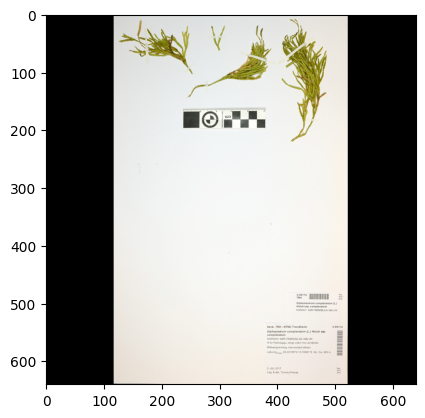

In [23]:
import matplotlib.pyplot as plt

new_image = resize_image_with_aspect_ratio('../images/upload/1802796785.jpg', 640, 640)

plt.imshow(new_image)

In [1]:
from ultralytics import YOLO, settings
import os
import numpy as np
import shutil
import random
import torch

torch.cuda.empty_cache()

IMG_PATH_FIXED = '/home/floris/Projects/NTNU/images/scale_fixed'
IMG_PATH_RANDOM = '/home/floris/Projects/NTNU/images/scale_random'
MODEL_PATH = '/home/floris/Projects/NTNU/models/classify_scale_medium_v2.pt'

settings.update({'runs_dir': '/home/floris/Projects/NTNU/models/runs'})

all_images_fixed = os.listdir(IMG_PATH_FIXED)
all_images_random = os.listdir(IMG_PATH_RANDOM)

test_images = [os.path.join(IMG_PATH_FIXED, img) for img in all_images_fixed]
# test_images2 = [os.path.join(IMG_PATH_RANDOM, img) for img in all_images_random]

# combined = test_images + test_images2
combined = test_images

model = YOLO(MODEL_PATH)

batch_size = 50
all_results = []
no_class = []

if len(combined) > batch_size:
    for i in range(0, len(combined), batch_size):
        results = model(combined[i:i+batch_size], save=True, conf=0.5, show_labels=False, show_conf=True)
        for r in results:
            cls = r.boxes.cls.cpu().numpy()
            cls_dict = {0: 'fixed', 1: 'random'}
            if len(cls) == 0:
                no_class.append(r.path)
            else:
                cls = cls_dict[cls[0]]
            all_results.append((r.path, cls))
else:
    results = model(combined, save=True, conf=0.5, show_labels=False, show_conf=True)


0: 640x640 1 scale_fixed, 6.1ms
1: 640x640 1 scale_fixed, 6.1ms
2: 640x640 1 scale_fixed, 6.1ms
3: 640x640 1 scale_fixed, 6.1ms
4: 640x640 1 scale_fixed, 6.1ms
5: 640x640 1 scale_fixed, 6.1ms
6: 640x640 1 scale_fixed, 6.1ms
7: 640x640 1 scale_fixed, 6.1ms
8: 640x640 1 scale_fixed, 6.1ms
9: 640x640 1 scale_fixed, 6.1ms
10: 640x640 1 scale_fixed, 6.1ms
11: 640x640 1 scale_fixed, 6.1ms
12: 640x640 1 scale_random, 6.1ms
13: 640x640 1 scale_fixed, 6.1ms
14: 640x640 1 scale_fixed, 6.1ms
15: 640x640 1 scale_fixed, 6.1ms
16: 640x640 1 scale_fixed, 6.1ms
17: 640x640 1 scale_fixed, 6.1ms
18: 640x640 1 scale_fixed, 6.1ms
19: 640x640 1 scale_fixed, 6.1ms
20: 640x640 1 scale_fixed, 6.1ms
21: 640x640 1 scale_fixed, 6.1ms
22: 640x640 1 scale_fixed, 6.1ms
23: 640x640 1 scale_fixed, 6.1ms
24: 640x640 1 scale_fixed, 6.1ms
25: 640x640 1 scale_fixed, 6.1ms
26: 640x640 1 scale_fixed, 6.1ms
27: 640x640 1 scale_fixed, 6.1ms
28: 640x640 1 scale_fixed, 6.1ms
29: 640x640 1 scale_fixed, 6.1ms
30: 640x640 1 scal

In [20]:
len(all_results)

290

Remove dominant color

In [6]:
from sklearn.cluster import KMeans
import numpy as np
from PIL import Image

def find_dominant_color(image, k=3):
    # Convert image to numpy array
    img_array = np.array(image)
    # Reshape it to a list of RGB values
    img_vector = img_array.reshape((-1, 3))
    # Run k-means on the pixel colors (fit only on a subsample to speed up)
    kmeans = KMeans(n_clusters=k, random_state=0).fit(img_vector[::50])
    # Get the dominant color
    dominant_color = kmeans.cluster_centers_[np.argmax(np.bincount(kmeans.labels_))]
    # Create a mask for pixels within a certain distance from the dominant color
    distances = np.sqrt(np.sum((img_vector - dominant_color) ** 2, axis=1))
    mask = distances < np.std(distances)
    # Turn the dominant color range to white
    img_vector[mask] = [255, 255, 255]
    result_img_array = img_vector.reshape(img_array.shape)
    # Convert the array back to an image
    result_img = Image.fromarray(result_img_array.astype('uint8'))
    return dominant_color, result_img

In [7]:
img_path = '/home/floris/Projects/NTNU/images/cropped_scales/random/1701288290_b.jpg'
img = Image.open(img_path)

dominant_color, result_img = find_dominant_color(img)

dominant_color

array([243.44901022, 243.67742755, 242.63856721])

(-0.5, 2953.5, 4722.5, -0.5)

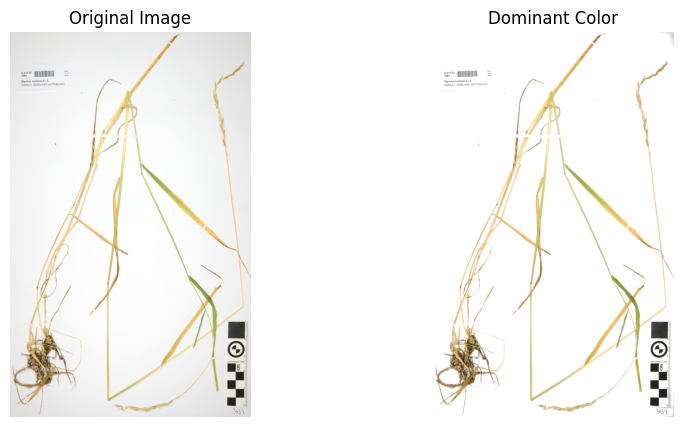

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(img)
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(result_img)
ax[1].set_title('Dominant Color')
ax[1].axis('off')

Create dataset for classification

In [6]:
import os
import shutil

path1 = '../images/classification/fixed'
path2 = '../images/classification/random'

save_path = '../images/cls_data'

os.makedirs(os.path.join(save_path, 'train', 'fixed'), exist_ok=True)
os.makedirs(os.path.join(save_path, 'train', 'random'), exist_ok=True)
os.makedirs(os.path.join(save_path, 'valid', 'fixed'), exist_ok=True)
os.makedirs(os.path.join(save_path, 'valid', 'random'), exist_ok=True)

fixed = os.listdir(path1)
random = os.listdir(path2)

train = len(fixed) // 100 * 90
train1 = len(random) // 100 * 90

for img_path in fixed[:train]:
    shutil.copy(os.path.join(path1, img_path), os.path.join(save_path, 'train', 'fixed', img_path))

for img_path in fixed[train:]:
    shutil.copy(os.path.join(path1, img_path), os.path.join(save_path, 'valid', 'fixed', img_path))

for img_path in random[:train1]:
    shutil.copy(os.path.join(path2, img_path), os.path.join(save_path, 'train', 'random', img_path))

for img_path in random[train1:]:
    shutil.copy(os.path.join(path2, img_path), os.path.join(save_path, 'valid', 'random', img_path))